# Initial Network File

In [1]:
import numpy as np
import sys
import random as rd
np.set_printoptions(threshold=sys.maxsize)

import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

from sklearn.model_selection import train_test_split

## Initial Data Load+Visualise

Data is stored in the same directory as this .ipynb file and loaded into the notebook below. A loop is run over each energy interval and a variable is allocated, using the `globals()` function, to the data from each file.

In [2]:
for i in np.arange(50,201,5):
    globals()['C_'+str(i)+'keV']=np.load('C_'+str(i)+'keV.npy') #

The shape of each loaded data file is output below - an array containing $5000$ $97\times97$ matrices.

In [3]:
np.shape(C_200keV)

(5000, 97, 97)

Each matrix can be selected using its index.

In [4]:
np.shape(C_100keV[0])

(97, 97)

We can print out one of the matrices for the `C_85keV` energy to visualise how the data is distributed.

In [5]:
C_85keV[500]

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,

The vast majority of pixels have entries of 0. Different energies and indices show a similar distribution. This means the recoil track is small relative to the image size.

Difficulty is encountered loading the data for Flourine. A loop is run below to identify at which energy this error occurs.

In [6]:
for i in np.arange(50,201,5):
    try:
        np.load('F_'+str(i)+'keV.npy')
    except:
        print('There is a problem with F_'+str(i)+'keV.npy')

There is a problem with F_200keV.npy


In [7]:
# np.load('F_200keV.npy')

There is an error with the `200keV` file for Flourine. I also noticed that all the other files are `376.4MB` but `F_200keV.npy` is `146.4MB`. This is due to a problem with the initial file (according to Tim). I will only use up to `195keV` for both Carbon and Flourine. I wouldn't want to train a model on `200keV` for one element but not the other (it could just assume that an energy of `200keV` makes something Carbon rather than finding the more complex features).

I plot out a random matrix from one of the energies to visualise it.

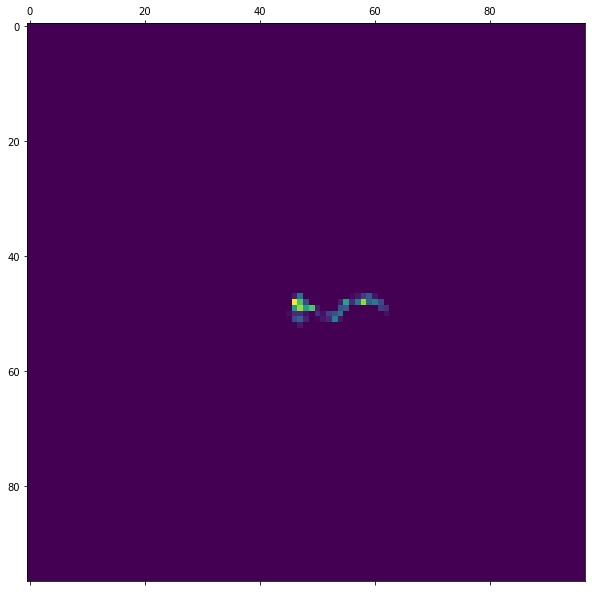

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.matshow(C_150keV[10],fignum=1)

## Preparing Data for Pytorch and CNN

For a learning algorithm, it will be necesarry to have an input (X data) containing a number of $97\times97$ matrices for each energy. The output will be a label, either Carbon or Flourine. The model will compare its output with the actual labels and adjust accordingly to minimise loss. 

In order to quantify each label, the common 'one-hot encoding' method will be used. C elements will have the label `[1, 0]` and F will be `[0, 1]`. Tuples of this form will be the ground truth labels and the model output. I will have to ensure that the model outputs an array of shape `[2]`.

In [9]:
im_dat, el_labs, en_labs = [],[],[]
for i in np.arange(50,196,5):
    C_dat = np.load('C_'+str(i)+'keV.npy')
    for n in range(np.shape(C_dat)[0]):
        im_dat.append(C_dat[n]),el_labs.append([1,0]),en_labs.append(i)
    F_dat = np.load('F_'+str(i)+'keV.npy')
    for n in range(np.shape(F_dat)[0]):
        im_dat.append(F_dat[n]),el_labs.append([0,1]),en_labs.append(i)

In [10]:
np.shape(im_dat)

(300000, 97, 97)

$300000$ is the number we want. Aka $5000\times2\times30$ (there are $30$ different energies for both C and F).

In [11]:
np.shape(el_labs)

(300000, 2)

In [12]:
el_labs[154999]

[1, 0]

In [13]:
np.shape(en_labs)

(300000,)

In [14]:
#writing class for custom dataset
class CustomDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data #initialises X_data
        self.y_data = y_data #initialises y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index] #returns one training example
        
    def __len__ (self):
        return len(self.X_data) #returns length of the dataset

**I need to split into training and testing data first**

# Classifying Energy

X data is the 97x97 arrays, 'im_dat'

y data in this case is list of energies, 'en_labs'

In [15]:
X_train, X_test, y_train, y_test = train_test_split(im_dat, el_labs, test_size=0.2, random_state=42)

In [16]:
X_train[1]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,

In [17]:
np.shape(X_train)

(240000, 97, 97)

In [18]:
np.shape(y_test)

(60000, 2)

In [19]:
X_train[1]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,

In order to apply a 2-dimensional CNN, it will be necessary to employ PyTorch's `nn.Conv2d()` function, which applies a 2D convolution over the input. `nn.Conv2d()` expects the input to be of the shape `[batch_size, input_channels, matrix_height, matrix_width]`, so we must ensure that the data is in this shape. Initially the data is in the shape `[batch_size, matrix_height, matrix_width]`, so an additional dimension must be added containing the number of input channels, which in this case is 1.

In [20]:
xtrain_tensor = torch.from_numpy(np.array(X_train)) #converts numpy array to torch tensor
xtrain_sqz = xtrain_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtrain_sqz.shape)

torch.Size([240000, 1, 97, 97])


In [21]:
ytrain_tensor = torch.from_numpy(np.array(y_train))
ytrain_sqz = ytrain_tensor.unsqueeze(1)
print(ytrain_sqz.shape)

torch.Size([240000, 1, 2])


Now for test data

In [22]:
xtest_tensor = torch.from_numpy(np.array(X_test)) #converts numpy array to torch tensor
xtest_sqz = xtest_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtest_sqz.shape)

torch.Size([60000, 1, 97, 97])


In [23]:
ytest_tensor = torch.from_numpy(np.array(y_test))
ytest_sqz = ytest_tensor.unsqueeze(1)
print(ytest_sqz.shape)

torch.Size([60000, 1, 2])


Applying dataset

In [24]:
#Converting data to floats and applying dataset class
train_data = CustomDataset(xtrain_sqz, ytrain_sqz)
test_data = CustomDataset(xtest_sqz, ytest_sqz)

In [25]:
# #Converting data to floats and applying dataset class
# train_data = CustomDataset(xtrain_sqz.float(), ytrain_sqz.float())
# test_data = CustomDataset(xtest_sqz.float(), ytest_sqz.float())

The Kernel dies when running the above. I have too much data.

## Reducing data

In [26]:
atest=rd.choices(X_train, k=3)
np.shape(atest)

(3, 97, 97)

In [27]:
X_train_small, X_test_small, y_train_small, y_test_small = rd.choices(X_train, k=2400), rd.choices(X_test, k=600),\
rd.choices(y_train, k=2400), rd.choices(y_test, k=600)

In [28]:
xtrain_tensor = torch.from_numpy(np.array(X_train_small)) #converts numpy array to torch tensor
xtrain_sqz = xtrain_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtrain_sqz.shape)

torch.Size([2400, 1, 97, 97])


In [29]:
ytrain_tensor = torch.from_numpy(np.array(y_train_small))
ytrain_sqz = ytrain_tensor.unsqueeze(1)
print(ytrain_sqz.shape)

torch.Size([2400, 1, 2])


In [30]:
xtest_tensor = torch.from_numpy(np.array(X_test_small)) #converts numpy array to torch tensor
xtest_sqz = xtest_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtest_sqz.shape)

torch.Size([600, 1, 97, 97])


In [31]:
ytest_tensor = torch.from_numpy(np.array(y_test_small))
ytest_sqz = ytest_tensor.unsqueeze(1)
print(ytest_sqz.shape)

torch.Size([600, 1, 2])


In [32]:
#Converting data to floats and applying dataset class
train_data = CustomDataset(xtrain_sqz.float(), ytrain_tensor.float()) #changed from sqz to float to long
test_data = CustomDataset(xtest_sqz.float(), ytest_tensor.float())

In [33]:
#defining dataloader class
train_loader = DataLoader(dataset=train_data, batch_size=50, shuffle=True)
train_loader_iter = iter(train_loader)
# print(next(train_loader_iter))

#testing to see shape of output
test=next(train_loader_iter)
test[0].shape

torch.Size([50, 1, 97, 97])

In [34]:
#same as above but for test data
test_loader = DataLoader(dataset=test_data, batch_size=50, shuffle=True)
test_loader_iter = iter(test_loader)

test=next(test_loader_iter)
test[0].shape

torch.Size([50, 1, 97, 97])

## Model

Code for finding maxpooling output

In [35]:
inp = torch.randn(50, 1, 97, 97)
m1 = nn.Conv2d(1, 5, kernel_size=(5,5))
o1 = m1(inp)
print(np.shape(o1))
m2 = nn.MaxPool2d(kernel_size=(3,3))
o2 = m2(o1)
print(np.shape(o2))
m3 = nn.Conv2d(5, 10, kernel_size=(5,5))
o3 = m3(o2)
print(np.shape(o3))
m4 = nn.MaxPool2d(kernel_size=(3,3))
o4 = m4(o3)
print(np.shape(o4))
o5 = o4.view(-1, 810)
print(np.shape(o5))
m6 = nn.Linear(810,80)
o6 = m6(o5)
print(np.shape(o6))
m7 = nn.Linear(80,2)
o7 = m7(o6)
print(np.shape(o7))

torch.Size([50, 5, 93, 93])
torch.Size([50, 5, 31, 31])
torch.Size([50, 10, 27, 27])
torch.Size([50, 10, 9, 9])
torch.Size([50, 810])
torch.Size([50, 80])
torch.Size([50, 2])


Previously I was going into the batch dimension by having the wrong dimensions for the flattening layer. I didn't realise that for the flattening it would (obviously) flatten across both dimensions.

In [36]:
device = torch.device('cpu')

#defining CNN class, see description below
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(3,3)),
            nn.ReLU(),
            nn.Conv2d(5, 10, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(3,3)),
            nn.ReLU(),
        )
            
        self.fc_layers = nn.Sequential(
            nn.Linear(810, 80),
            nn.ReLU(),
            nn.Linear(80,2),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 810) #flattens as described below
#         x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [37]:
batch_size = 5

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    #loop run over data output by loader to train model
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data) #applies model to data
        target = target.squeeze(1) #removes dimension from target
        loss = nn.CrossEntropyLoss()(output, target) #calculates cross entropy loss
        loss.backward()
        optimizer.step() #new step in optimisation of loss
        #printing output of each batch for loss observation while model is training
        if batch_idx % batch_size == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    #initialisting parameters and empty lists
    test_loss = 0
    correct = 0
    probs_pred = []
    labels_actual = []
    labels_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            target=target.squeeze(1)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
        
            pred = output.max(1, keepdim=True)[1] #finds index of maximum in output vector as described below
            pred_onehot = F.one_hot(pred).squeeze(1) #converts into one-hot predicted label 
            pred_bool = torch.eq(pred_onehot,target) #finds values where predicted equals target
            correct += int((pred_bool.sum().item())/2) #sums number of correct values
            #adds predicted labels, targets and probabilities to lists for later use
            labels_actual.append(target.numpy())
            probs_pred.append(output.numpy())
            labels_pred.append(pred_onehot.numpy())
 
    #printing accuracy and loss after each epoch for analysis
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100 * correct / len(test_loader.dataset)))
    
    return(labels_actual,probs_pred,labels_pred)

In [38]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(np.shape(target))

torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])
torch.Size([50, 2])


In [39]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5) #stochastic gradient descent used as optimiser

In [40]:
#outputting variables from initial model
initial_model = model
print(model)
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=810, out_features=80, bias=True)
    (1): ReLU()
    (2): Linear(in_features=80, out_features=2, bias=True)
    (3): Softmax(dim=1)
  )
)


(66432, [125, 5, 1250, 10, 64800, 80, 160, 2])

In [41]:
num_epochs = 5 #setting number of epochs for CNN

#running loop training and testing over previously specified number of epochs
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    act,pred,pred_labs = test(model, device, test_loader)

Train Epoch: 1 [0/2400 (0%)]	Loss: 0.677595
Train Epoch: 1 [250/2400 (10%)]	Loss: 0.890753
Train Epoch: 1 [500/2400 (21%)]	Loss: 0.827270
Train Epoch: 1 [750/2400 (31%)]	Loss: 0.744483
Train Epoch: 1 [1000/2400 (42%)]	Loss: 0.693578
Train Epoch: 1 [1250/2400 (52%)]	Loss: 0.705829
Train Epoch: 1 [1500/2400 (62%)]	Loss: 0.696078
Train Epoch: 1 [1750/2400 (73%)]	Loss: 0.690527
Train Epoch: 1 [2000/2400 (83%)]	Loss: 0.703200
Train Epoch: 1 [2250/2400 (94%)]	Loss: 0.692950

Test set: Average loss: 0.0139, Accuracy: 287/600 (48%)

Train Epoch: 2 [0/2400 (0%)]	Loss: 0.691314
Train Epoch: 2 [250/2400 (10%)]	Loss: 0.696583
Train Epoch: 2 [500/2400 (21%)]	Loss: 0.693338
Train Epoch: 2 [750/2400 (31%)]	Loss: 0.689920
Train Epoch: 2 [1000/2400 (42%)]	Loss: 0.692899
Train Epoch: 2 [1250/2400 (52%)]	Loss: 0.695329
Train Epoch: 2 [1500/2400 (62%)]	Loss: 0.689294
Train Epoch: 2 [1750/2400 (73%)]	Loss: 0.684728
Train Epoch: 2 [2000/2400 (83%)]	Loss: 0.683980
Train Epoch: 2 [2250/2400 (94%)]	Loss: 0.690

In [42]:
print(batch_size)

5


# Trying another model

In [43]:
inp = torch.randn(50, 1, 97, 97)
m1 = nn.Conv2d(1, 5, kernel_size=(6,6))
o1 = m1(inp)
print(np.shape(o1))
m2 = nn.MaxPool2d(kernel_size=(2,2))
o2 = m2(o1)
print(np.shape(o2))
m3 = nn.Conv2d(5, 10, kernel_size=(5,5))
o3 = m3(o2)
print(np.shape(o3))
m4 = nn.MaxPool2d(kernel_size=(2,2))
o4 = m4(o3)
print(np.shape(o4))
m5 = nn.Conv2d(10, 50, kernel_size=(6,6))
o5 = m5(o4)
print(np.shape(o5))
m6 = nn.MaxPool2d(kernel_size=(2,2))
o6 = m6(o5)
print(np.shape(o6))


o7 = o6.view(-1, 3200)
print(np.shape(o7))
m8 = nn.Linear(3200,1000)
o8 = m8(o7)
print(np.shape(o8))
m9 = nn.Linear(1000,300)
o9 = m9(o8)
print(np.shape(o9))
m10 = nn.Linear(300,80)
o10 = m10(o9)
print(np.shape(o10))
m11 = nn.Linear(80,2)
o11 = m11(o10)
print(np.shape(o11))

torch.Size([50, 5, 92, 92])
torch.Size([50, 5, 46, 46])
torch.Size([50, 10, 42, 42])
torch.Size([50, 10, 21, 21])
torch.Size([50, 50, 16, 16])
torch.Size([50, 50, 8, 8])
torch.Size([50, 3200])
torch.Size([50, 1000])
torch.Size([50, 300])
torch.Size([50, 80])
torch.Size([50, 2])


In [44]:
device = torch.device('cpu')

#defining CNN class, see description below
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=(6,6)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Conv2d(5, 10, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Conv2d(10, 50, kernel_size=(6,6)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
        )
            
        self.fc_layers = nn.Sequential(
            nn.Linear(3200,1000),
            nn.ReLU(),
            nn.Linear(1000,300),
            nn.ReLU(),
            nn.Linear(300,80),
            nn.ReLU(),
            nn.Linear(80,2),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 3200) #flattens as described below
#         x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [45]:
model = Net().to(device)
#model.load_state_dict(torch.load('./data/mnist_cnns.pth'))
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5) #stochastic gradient descent used as optimiser

In [46]:
#outputting variables from initial model
initial_model = model
print(model)
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 5, kernel_size=(6, 6), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(10, 50, kernel_size=(6, 6), stride=(1, 1))
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=3200, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=80, bias=True)
    (5): ReLU()
    (6): Linear(in_features=80, out_features=2, bias=True)
    (7): Softmax(dim=1)
  )
)


(3545037,
 [180, 5, 1250, 10, 18000, 50, 3200000, 1000, 300000, 300, 24000, 80, 160, 2])

In [47]:
num_epochs = 8 #setting number of epochs for CNN

#running loop training and testing over previously specified number of epochs
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    act,pred,pred_labs = test(model, device, test_loader)

Train Epoch: 1 [0/2400 (0%)]	Loss: 0.699623
Train Epoch: 1 [250/2400 (10%)]	Loss: 0.684475
Train Epoch: 1 [500/2400 (21%)]	Loss: 0.700075
Train Epoch: 1 [750/2400 (31%)]	Loss: 0.691101
Train Epoch: 1 [1000/2400 (42%)]	Loss: 0.686682
Train Epoch: 1 [1250/2400 (52%)]	Loss: 0.691045
Train Epoch: 1 [1500/2400 (62%)]	Loss: 0.693372
Train Epoch: 1 [1750/2400 (73%)]	Loss: 0.695435
Train Epoch: 1 [2000/2400 (83%)]	Loss: 0.687645
Train Epoch: 1 [2250/2400 (94%)]	Loss: 0.690408

Test set: Average loss: 0.0139, Accuracy: 306/600 (51%)

Train Epoch: 2 [0/2400 (0%)]	Loss: 0.691529
Train Epoch: 2 [250/2400 (10%)]	Loss: 0.692764
Train Epoch: 2 [500/2400 (21%)]	Loss: 0.693688
Train Epoch: 2 [750/2400 (31%)]	Loss: 0.694803
Train Epoch: 2 [1000/2400 (42%)]	Loss: 0.695540
Train Epoch: 2 [1250/2400 (52%)]	Loss: 0.691899
Train Epoch: 2 [1500/2400 (62%)]	Loss: 0.692208
Train Epoch: 2 [1750/2400 (73%)]	Loss: 0.694776
Train Epoch: 2 [2000/2400 (83%)]	Loss: 0.690790
Train Epoch: 2 [2250/2400 (94%)]	Loss: 0.692

That's probably the best accuracy I can get with this much data.

## More Data

In [48]:
X_train_small, X_test_small, y_train_small, y_test_small = rd.choices(X_train, k=24000), rd.choices(X_test, k=6000),\
rd.choices(y_train, k=24000), rd.choices(y_test, k=6000)

In [49]:
xtrain_tensor = torch.from_numpy(np.array(X_train_small)) #converts numpy array to torch tensor
xtrain_sqz = xtrain_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtrain_sqz.shape)

torch.Size([24000, 1, 97, 97])


In [50]:
ytrain_tensor = torch.from_numpy(np.array(y_train_small))
ytrain_sqz = ytrain_tensor.unsqueeze(1)
print(ytrain_sqz.shape)

torch.Size([24000, 1, 2])


In [51]:
xtest_tensor = torch.from_numpy(np.array(X_test_small)) #converts numpy array to torch tensor
xtest_sqz = xtest_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtest_sqz.shape)

torch.Size([6000, 1, 97, 97])


In [52]:
ytest_tensor = torch.from_numpy(np.array(y_test_small))
ytest_sqz = ytest_tensor.unsqueeze(1)
print(ytest_sqz.shape)

torch.Size([6000, 1, 2])


In [53]:
#Converting data to floats and applying dataset class
train_data = CustomDataset(xtrain_sqz.float(), ytrain_tensor.float()) #changed from sqz to float to long
test_data = CustomDataset(xtest_sqz.float(), ytest_tensor.float())

In [54]:
#defining dataloader class
train_loader = DataLoader(dataset=train_data, batch_size=50, shuffle=True)
train_loader_iter = iter(train_loader)
# print(next(train_loader_iter))

#testing to see shape of output
test=next(train_loader_iter)
test[0].shape

torch.Size([50, 1, 97, 97])

In [55]:
#same as above but for test data
test_loader = DataLoader(dataset=test_data, batch_size=50, shuffle=True)
test_loader_iter = iter(test_loader)

test=next(test_loader_iter)
test[0].shape

torch.Size([50, 1, 97, 97])

In [56]:
device = torch.device('cpu')

#defining CNN class, see description below
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=(6,6)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Conv2d(5, 10, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Conv2d(10, 50, kernel_size=(6,6)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
        )
            
        self.fc_layers = nn.Sequential(
            nn.Linear(3200,1000),
            nn.ReLU(),
            nn.Linear(1000,300),
            nn.ReLU(),
            nn.Linear(300,80),
            nn.ReLU(),
            nn.Linear(80,2),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 3200) #flattens as described below
#         x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [57]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    #loop run over data output by loader to train model
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data) #applies model to data
        target = target.squeeze(1) #removes dimension from target
        loss = nn.CrossEntropyLoss()(output, target) #calculates cross entropy loss
        loss.backward()
        optimizer.step() #new step in optimisation of loss
        #printing output of each batch for loss observation while model is training
        if batch_idx % batch_size == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    #initialisting parameters and empty lists
    test_loss = 0
    correct = 0
    probs_pred = []
    labels_actual = []
    labels_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            target=target.squeeze(1)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
        
            pred = output.max(1, keepdim=True)[1] #finds index of maximum in output vector as described below
            pred_onehot = F.one_hot(pred).squeeze(1) #converts into one-hot predicted label 
            pred_bool = torch.eq(pred_onehot,target) #finds values where predicted equals target
            correct += int((pred_bool.sum().item())/2) #sums number of correct values
            #adds predicted labels, targets and probabilities to lists for later use
            labels_actual.append(target.numpy())
            probs_pred.append(output.numpy())
            labels_pred.append(pred_onehot.numpy())
 
    #printing accuracy and loss after each epoch for analysis
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100 * correct / len(test_loader.dataset)))
    
    return(labels_actual,probs_pred,labels_pred)

In [58]:
#outputting variables from initial model
initial_model = model
print(model)
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 5, kernel_size=(6, 6), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(10, 50, kernel_size=(6, 6), stride=(1, 1))
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=3200, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=80, bias=True)
    (5): ReLU()
    (6): Linear(in_features=80, out_features=2, bias=True)
    (7): Softmax(dim=1)
  )
)


(3545037,
 [180, 5, 1250, 10, 18000, 50, 3200000, 1000, 300000, 300, 24000, 80, 160, 2])

I've read that 3e-4 is a good learning rate for Adam. Obviously it is very much dependent on the model.

In [59]:
model = Net().to(device)
#model.load_state_dict(torch.load('./data/mnist_cnns.pth'))
optimizer = optim.Adam(model.parameters(), lr=3e-4) #stochastic gradient descent used as optimiser

In [61]:
num_epochs = 10 #setting number of epochs for CNN
batch_size = 100

#running loop training and testing over previously specified number of epochs
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    act,pred,pred_labs = test(model, device, test_loader)

Train Epoch: 1 [0/24000 (0%)]	Loss: 0.689325
Train Epoch: 1 [5000/24000 (21%)]	Loss: 0.678720
Train Epoch: 1 [10000/24000 (42%)]	Loss: 0.672766
Train Epoch: 1 [15000/24000 (62%)]	Loss: 0.669874
Train Epoch: 1 [20000/24000 (83%)]	Loss: 0.686136

Test set: Average loss: 0.0141, Accuracy: 2978/6000 (50%)

Train Epoch: 2 [0/24000 (0%)]	Loss: 0.678059
Train Epoch: 2 [5000/24000 (21%)]	Loss: 0.656276
Train Epoch: 2 [10000/24000 (42%)]	Loss: 0.650396
Train Epoch: 2 [15000/24000 (62%)]	Loss: 0.672126
Train Epoch: 2 [20000/24000 (83%)]	Loss: 0.671075

Test set: Average loss: 0.0142, Accuracy: 2974/6000 (50%)

Train Epoch: 3 [0/24000 (0%)]	Loss: 0.656424
Train Epoch: 3 [5000/24000 (21%)]	Loss: 0.673149
Train Epoch: 3 [10000/24000 (42%)]	Loss: 0.657671
Train Epoch: 3 [15000/24000 (62%)]	Loss: 0.610100
Train Epoch: 3 [20000/24000 (83%)]	Loss: 0.651316

Test set: Average loss: 0.0146, Accuracy: 3007/6000 (50%)

Train Epoch: 4 [0/24000 (0%)]	Loss: 0.572785
Train Epoch: 4 [5000/24000 (21%)]	Loss: 0.6

I need GPU acceleration.

- Use Sigmoid instead of Softmax in last layer
- Use regularisation like L1, L2 and dropout
- Use more convolutional layers, a larger network

*Visualising difficulty in classification*

In [62]:
for i in np.arange(50,61,5):
    globals()['F_'+str(i)+'keV']=np.load('F_'+str(i)+'keV.npy') #

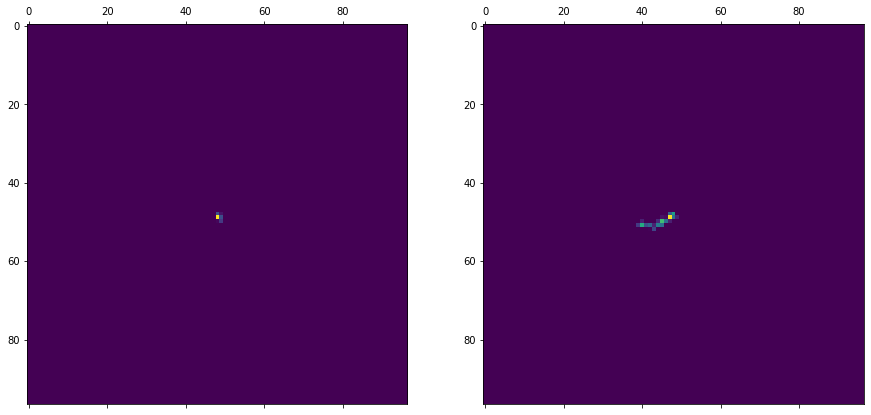

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.matshow(F_50keV[25])
ax2.matshow(C_50keV[25]);

They're both similar and hard to classify. Theoretically it's possible but a very complex network will be necesarry with lots of data. My computer can't handle that.